In [1]:
import warnings
warnings.filterwarnings("ignore")
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler

import acquire, prepare, env

### Acquire

In [2]:
df = acquire.get_mall_data()
df.head()

,customer_id,gender,age,annual_income,spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


### Summarize the data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     200 non-null    int64 
 1   gender          200 non-null    object
 2   age             200 non-null    int64 
 3   annual_income   200 non-null    int64 
 4   spending_score  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 9.4+ KB


In [5]:
df.nunique()

customer_id       200
gender              2
age                51
annual_income      64
spending_score     84
dtype: int64

**Takeaways**
1. encode gender
2. drop customer_id
3. define our target: spending_score

In [4]:
df.describe()

,customer_id,age,annual_income,spending_score
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


**Takeaways**
1. not sure how annual income is computed, or what units it is in.
2. don't know what spending score means, assuming higher spending score means more likely to spend, better to market to?

### Plot distribution of each variable

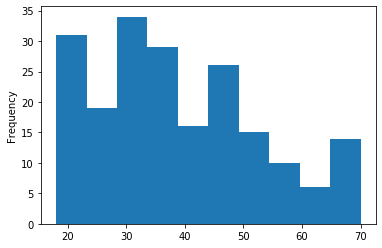

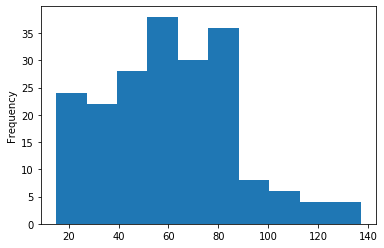

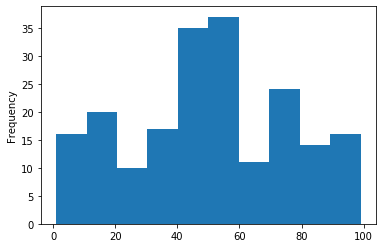

In [6]:
# Distribution plot of numeric variables: ['age', 'annual_income', 'spending_score']

for col in ['age', 'annual_income', 'spending_score']:
    df[col].plot.hist()
    plt.show()

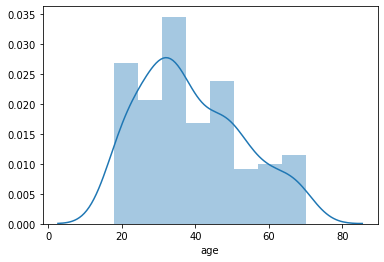

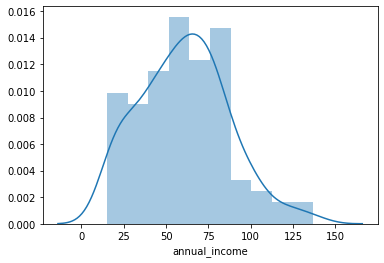

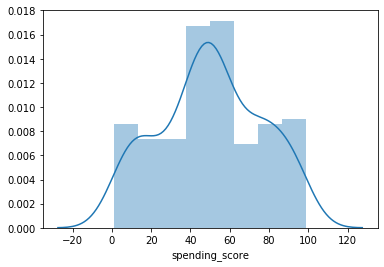

In [7]:
for col in ['age', 'annual_income', 'spending_score']:
    sns.distplot(df[col])
    plt.show()

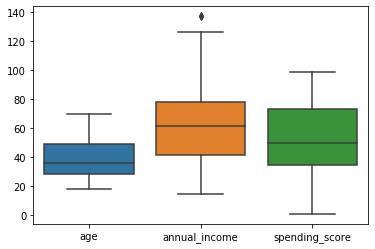

In [8]:
# Boxplot numeric variable with simialr scale

sns.boxplot(data=df[['age', 'annual_income', 'spending_score']])

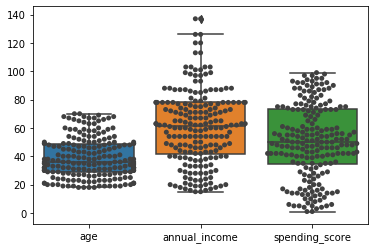

In [17]:
# Add swarmplot() to show datapoints on top of the boxes

cols = ['age', 'annual_income', 'spending_score']
ax = sns.boxplot(data=df[cols])
ax = sns.swarmplot(data=df[cols], color='.25')

### Detect missing values

In [18]:
df.isna().sum()

customer_id       0
gender            0
age               0
annual_income     0
spending_score    0
dtype: int64

In [19]:
df.isnull().sum()

customer_id       0
gender            0
age               0
annual_income     0
spending_score    0
dtype: int64

**Takeaways**
1. No missing values exit. 

### Demo: turn a continuous variable (age) into a categorical one by putting the numeric features into bins

In [26]:
pd.cut(df.age, bins=4).value_counts()

(17.948, 31.0]    70
(31.0, 44.0]      61
(44.0, 57.0]      43
(57.0, 70.0]      26
Name: age, dtype: int64

In [21]:
pd.qcut(df.age, q=4).value_counts().sort_index()

(17.999, 28.75]    50
(28.75, 36.0]      54
(36.0, 49.0]       51
(49.0, 70.0]       45
Name: age, dtype: int64

In [22]:
pd.cut(df.age, bins=[0, 30, 50, 100]).value_counts()

(30, 50]     98
(0, 30]      62
(50, 100]    40
Name: age, dtype: int64

### Encode bianry varibale: gender

In [23]:
df['is_female'] = (df.gender == 'Female').astype('int')
df.head()

,customer_id,gender,age,annual_income,spending_score,is_female
0,1,Male,19,15,39,0
1,2,Male,21,15,81,0
2,3,Female,20,16,6,1
3,4,Female,23,16,77,1
4,5,Female,31,17,40,1


### Split the data into train, validate and test

In [24]:
train_validate, test = train_test_split(df, test_size=.15, random_state=442)
train, validate = train_test_split(train_validate, test_size=.15, random_state=442)

train.shape, validate.shape, test.shape

((144, 6), (26, 6), (30, 6))

### Put all the df modifications together into a function

In [27]:
df = acquire.get_mall_data()

def prep_mall(df):
    '''
    Takes the acquired mall data, does data prep, and returns
    train, test, and validate data splits.
    '''
    df['is_female'] = (df.gender == 'Female').astype('int')
    train_validate, test = train_test_split(df, test_size=.15, random_state=442)
    train, validate = train_test_split(train_validate, test_size=.15, random_state=442)
    return train, validate, test

### Acqure telco data for total spending analysis

In [31]:
def get_connection(db, user=env.user, host=env.host, password=env.password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

def get_telco_data():
    filename = 'telco_spend.csv'
    
    if os.path.isfile(filename):
        return pd.read_csv(filename, index_col=0)
    else: 
        df = pd.read_sql("""select customer_id, monthly_charges, tenure, total_charges
                    from customers
                    join contract_types using(contract_type_id)
                    where contract_type = 'Two year'""", get_connection('telco_churn'))
        df.to_csv(filename)
        return df

In [52]:
df = get_telco_data()
df.head()

,customer_id,monthly_charges,tenure,total_charges
0,0013-SMEOE,109.70,71,7904.25
1,0014-BMAQU,84.65,63,5377.8
2,0016-QLJIS,90.45,65,5957.9
3,0017-DINOC,45.20,54,2460.55
4,0017-IUDMW,116.80,72,8456.75


### Summarize telco data

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1695 entries, 0 to 1694
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customer_id      1695 non-null   object 
 1   monthly_charges  1695 non-null   float64
 2   tenure           1695 non-null   int64  
 3   total_charges    1695 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 66.2+ KB


In [54]:
df.duplicated().any()

False

In [55]:
df.nunique()

customer_id        1695
monthly_charges     820
tenure               73
total_charges      1678
dtype: int64

In [56]:
df.describe()

,monthly_charges,tenure
count,1695.000000,1695.000000
mean,60.770413,56.735103
std,34.678865,18.209363
min,18.400000,0.000000
25%,24.025000,48.000000
50%,64.350000,64.000000
75%,90.450000,71.000000
max,118.750000,72.000000


**Takeaways**
1. No null value.
2. No duplciated rows
3. Column total_charges needs to be numeric. 

### Turn total charges to numeric

In [57]:
df.total_charges.apply(lambda i: float(i))

ValueError: could not convert string to float: 

**Takeaways**
1. ValueError is return, which indicates not all values in col 'total_charges' are string numbers. 
2. What could they be?

In [58]:
boolean = df.total_charges.str.isspace()
df[boolean]

,customer_id,monthly_charges,tenure,total_charges
234,1371-DWPAZ,56.05,0,
416,2520-SGTTA,20.00,0,
453,2775-SEFEE,61.90,0,
505,3115-CZMZD,20.25,0,
524,3213-VVOLG,25.35,0,
678,4075-WKNIU,73.35,0,
716,4367-NUYAO,25.75,0,
726,4472-LVYGI,52.55,0,
941,5709-LVOEQ,80.85,0,
1293,7644-OMVMY,19.85,0,


In [59]:
boolean_1 = df.tenure == 0 
df[boolean_1]

,customer_id,monthly_charges,tenure,total_charges
234,1371-DWPAZ,56.05,0,
416,2520-SGTTA,20.00,0,
453,2775-SEFEE,61.90,0,
505,3115-CZMZD,20.25,0,
524,3213-VVOLG,25.35,0,
678,4075-WKNIU,73.35,0,
716,4367-NUYAO,25.75,0,
726,4472-LVYGI,52.55,0,
941,5709-LVOEQ,80.85,0,
1293,7644-OMVMY,19.85,0,


**Takeaways**
1. Whitespace are found in col 'total_charges'.
2. The reasons may be that the customers are new and have not been charged yet. 
3. Since there are only 10 of them, so dropping them has little impact on the sample size. 

In [60]:
# Drop the rows with missing total charges. 

df = df[-boolean]
df.shape

(1685, 4)

In [61]:
df.head()

,customer_id,monthly_charges,tenure,total_charges
0,0013-SMEOE,109.70,71,7904.25
1,0014-BMAQU,84.65,63,5377.8
2,0016-QLJIS,90.45,65,5957.9
3,0017-DINOC,45.20,54,2460.55
4,0017-IUDMW,116.80,72,8456.75


In [62]:
# Convert `total_charges` to float

df['total_charges'] = df.total_charges.apply(lambda i: float(i))
df.dtypes

customer_id         object
monthly_charges    float64
tenure               int64
total_charges      float64
dtype: object

In [63]:
df.shape

(1685, 4)

In [64]:
# split the data to train, validate and test

train_validate, test = train_test_split(df, test_size=.15, random_state=442)
train, validate = train_test_split(train_validate, test_size=.175, random_state=442)

train.shape, validate.shape, test.shape

((1181, 4), (251, 4), (253, 4))

In [72]:
# Combine all the modifications steps together into a function
    
def wrangle_telco():
    df = get_telco_data()
    boolean = df.total_charges.str.isspace()
    df = df[-boolean]
    df['total_charges'] = df.total_charges.apply(lambda i: float(i))
    df.reset_index(drop=True, inplace=True)
    train_validate, test = train_test_split(df, test_size=.15, random_state=442)
    train, validate = train_test_split(train_validate, test_size=.175, random_state=442)
    return train, validate, test

In [73]:
# Test wrangle_telco function

train, validate, test = wrangle_telco()

In [74]:
train.shape

(1181, 4)

In [75]:
train.dtypes

customer_id         object
monthly_charges    float64
tenure               int64
total_charges      float64
dtype: object

**Takeaways**: function wrangle_telco works and is ready to be conversted to .py.